In [47]:
# import the necessary packages
import os
# define the base path to the input dataset and then use it to derive
# the path to the images directory and annotation CSV file
BASE_PATH = "./input/stanford-dogs-dataset/"
IMAGES_PATH = os.path.sep.join([BASE_PATH, "images/Images/"])
ANNOTS_PATH = os.path.sep.join([BASE_PATH, "annotations/Annotations"])


In [48]:
# define the path to the base output directory
BASE_OUTPUT = "output"
# define the path to the output serialized model, model training plot,
# and testing image filenames
MODEL_PATH = os.path.sep.join([BASE_OUTPUT, "detector.h5"])
PLOT_PATH = os.path.sep.join([BASE_OUTPUT, "plot.png"])
TEST_FILENAMES = BASE_OUTPUT + "/test_images.txt"

In [49]:
# initialize our initial learning rate, number of epochs to train
# for, and the batch size
INIT_LR = 1e-4
NUM_EPOCHS = 10
BATCH_SIZE = 32

##### Imports

Primary references: https://www.kaggle.com/sevvalbicer/dense-net-dog-image-classification#Testing (herein referred to as DenseRef) and https://www.kaggle.com/michaelfumery/computer-vision-cnn-stanford-dogs-dataset (herein referred to as XceptRef).

In [50]:
import pandas as pd
import os, cv2
import numpy as np
import tensorflow as tf
from tensorflow.python import keras

from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten,  AveragePooling2D
from keras.layers.convolutional import Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import SGD
from keras.layers import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array, array_to_img, load_img
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint

from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam, SGD, Adadelta

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from PIL import Image

import chitra
from chitra.dataloader import Clf

from tensorflow.python.client import device_lib
# import the necessary packages
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os

### Data Loading and Analysis

Number of breeds in dataset: 120


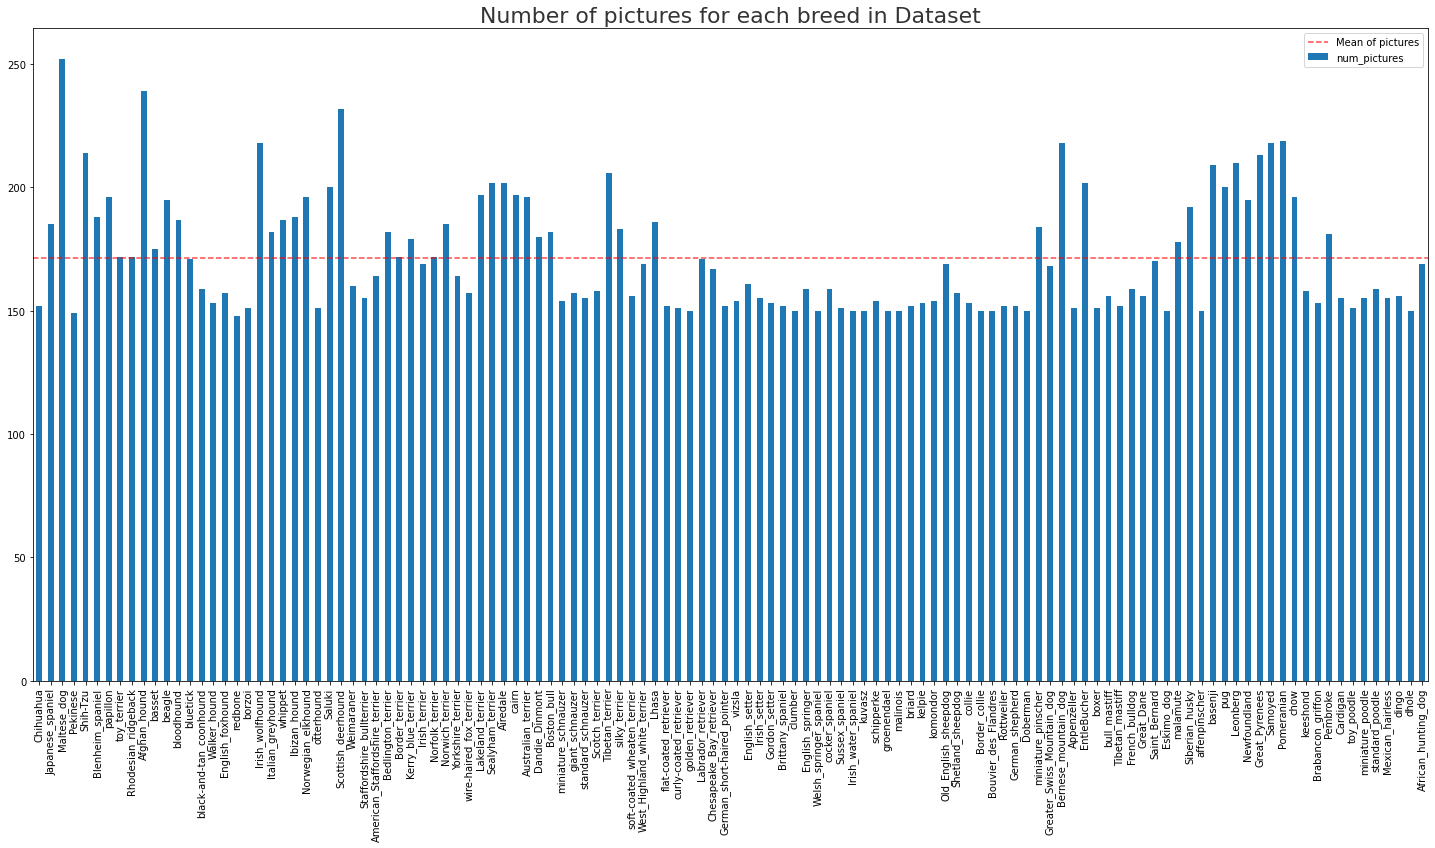

In [51]:
#From XceptRef

#Define paths
images_dir = "./input/stanford-dogs-dataset/images/Images/"
annotations_dir = '../input/stanford-dogs-dataset/annotations/Annotation'

# Count the number of classes (dogs breeds)
breed_list = os.listdir(images_dir)
print("Number of breeds in dataset:", (len(breed_list)))

#From XceptRef
# Count number of pictures for each breed
df_breeds = pd.DataFrame(
    index=[breed.split('-',1)[1] for breed in breed_list],
    data=[len(os.listdir(images_dir + "/" + name)) for name in breed_list],
    columns=["num_pictures"])

# Plot results
fig, ax = plt.subplots(1, 1, figsize=(25,12))
df_breeds.plot(kind="bar",legend=False, ax=ax)
ax.axhline(df_breeds["num_pictures"].mean(), color='r', alpha=.7, linestyle='--', label="Mean of pictures")
plt.title("Number of pictures for each breed in Dataset", color="#343434", fontsize=22)
plt.legend()
plt.show()

In [52]:
#From DenseRef with modifications - load categories
categories = [
    'n02096294-Australian_terrier',
    'n02093256-Staffordshire_bullterrier',
    'n02099601-golden_retriever',
    'n02106662-German_shepherd',
    'n02086240-Shih-Tzu',
    'n02099712-Labrador_retriever',
    'n02088364-beagle',
    'n02100735-English_setter',
    'n02102318-cocker_spaniel',
    'n02108915-French_bulldog',
    'n02094433-Yorkshire_terrier',
    'n02085620-Chihuahua',
    'n02110185-Siberian_husky',
    'n02106166-Border_collie',
    'n02106550-Rottweiler']
print("List of categories = ",categories,"\n\nNo. of categories = ", len(categories))


List of categories =  ['n02096294-Australian_terrier', 'n02093256-Staffordshire_bullterrier', 'n02099601-golden_retriever', 'n02106662-German_shepherd', 'n02086240-Shih-Tzu', 'n02099712-Labrador_retriever', 'n02088364-beagle', 'n02100735-English_setter', 'n02102318-cocker_spaniel', 'n02108915-French_bulldog', 'n02094433-Yorkshire_terrier', 'n02085620-Chihuahua', 'n02110185-Siberian_husky', 'n02106166-Border_collie', 'n02106550-Rottweiler'] 

No. of categories =  15


DenseRef limited their project to the first 20 categories.

As XceptRef pointed out, the categories are all well-represented such that the classes should be equal enough to all be used. XceptRef used 15 of the 20 most popular dog breeds in France for their categories. We'll start by testing DenseRef on these 15 breeds so the results are more comparable, but after we'll randomize them as should be done for proper experimental methodology.

Let's take a look at what some of these (random) images look like.

As noted by XceptRef and performed by both XceptRef and DenseRef, the images have inconsistent sizes. We need to rescale them so they are equal sizes.

https://www.kaggle.com/msripooja/dog-images-classification-using-keras-alexnet#6.-Predict-values-using-the-trained-model (AlexRef) has a resizing function that was also used in DenseRef, so we'll borrow that. We also then need to load the images. This can also be done using a pandas DataFrame (as done for Xception and seen earlier when examining data), but we'll start by using numpy arrays.

## Preprocessing the Data - DenseRef Method

In [53]:
import xml.etree.ElementTree as ET
def getBBox(category,image_name):
    root = ET.parse('input/stanford-dogs-dataset/annotations/Annotation/'+category+'/'+image_name).getroot()
    for type_tag in root.findall('object/bndbox'):
        xmin = int(type_tag.findtext('xmin'))
        ymin = int(type_tag.findtext('ymin'))
        xmax = int(type_tag.findtext('xmax'))
        ymax = int(type_tag.findtext('ymax'))
    return [xmin,ymin,xmax,ymax]

In [54]:
from chitra.image import Chitra
#From DenseRef/AlexRef with modifications
def load_images_and_labels(categories):
    # img_lst=[]
    # labels=[]
    # images_with_box=[]
    # label = ['dog']
    # index = 0

    data = []
    targets = []
    filenames = []
    for index, category in enumerate(categories):
        for image_name in os.listdir(images_dir+"/"+category):
            box = getBBox(category, image_name[:-3]) #[:-3] to remove .jpg from image filename

            # derive the path to the input image, load the image (in OpenCV format), and grab its dimensions
            imagePath = os.path.sep.join([IMAGES_PATH, category])
            imagePath = os.path.sep.join([imagePath, image_name])
            image = cv2.imread(imagePath)
            (h, w) = image.shape[:2]
            # scale the bounding box coordinates relative to the spatial
            # dimensions of the input image
            # print(box)
            startX = float(box[0]) / w
            startY = float(box[1]) / h
            endX = float(box[2]) / w
            endY = float(box[3]) / h

            # load the image and preprocess it
            image = load_img(imagePath, target_size=(224, 224))
            image = img_to_array(image)
            # update our list of data, targets, and filenames
            data.append(image)
            targets.append((startX, startY, endX, endY))
            filenames.append(image_name)

    return data, targets, filenames

data, targets, filenames = load_images_and_labels(categories)
# print("No. of images loaded = ",len(images),"\nNo. of labels loaded = ",len(labels))
#
# images = np.array(images)
# labels = np.array(labels)
#
# print("Images shape = ",images.shape,"\nLabels shape = ",labels.shape)

In [55]:
# convert the data and targets to NumPy arrays, scaling the input
# pixel intensities from the range [0, 255] to [0, 1]
data = np.array(data, dtype="float32") / 255.0
targets = np.array(targets, dtype="float32")
# partition the data into training and testing splits using 90% of
# the data for training and the remaining 10% for testing
split = train_test_split(data, targets, filenames, test_size=0.10,
	random_state=42)
# unpack the data split
(trainImages, testImages) = split[:2]
(trainTargets, testTargets) = split[2:4]
(trainFilenames, testFilenames) = split[4:]
# write the testing filenames to disk so that we can use then
# when evaluating/testing our bounding box regressor
print("[INFO] saving testing filenames...")
f = open(TEST_FILENAMES, "w")
f.write("\n".join(testFilenames))
f.close()

[INFO] saving testing filenames...


In [56]:
# load the VGG16 network, ensuring the head FC layers are left off
vgg = VGG16(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))
# freeze all VGG layers so they will *not* be updated during the
# training process
vgg.trainable = False
# flatten the max-pooling output of VGG
flatten = vgg.output
flatten = Flatten()(flatten)
# construct a fully-connected layer header to output the predicted
# bounding box coordinates
bboxHead = Dense(128, activation="relu")(flatten)
bboxHead = Dense(64, activation="relu")(bboxHead)
bboxHead = Dense(32, activation="relu")(bboxHead)
bboxHead = Dense(4, activation="sigmoid")(bboxHead)
# construct the model we will fine-tune for bounding box regression
model = Model(inputs=vgg.input, outputs=bboxHead)

In [58]:
# initialize the optimizer, compile the model, and show the model
# summary
opt = Adam(lr=INIT_LR)
model.compile(loss="mse", optimizer=opt)
print(model.summary())
# train the network for bounding box regression
print("[INFO] training bounding box regressor...")
H = model.fit(
	trainImages, trainTargets,
	validation_data=(testImages, testTargets),
	batch_size=BATCH_SIZE,
	epochs=NUM_EPOCHS,
	verbose=1)

71/71 [==============================] - 248s 3s/step - loss: 0.0180 - val_loss: 0.0113

[INFO] saving object detector model...


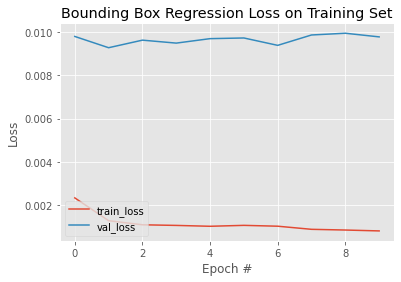

In [59]:
# serialize the model to disk
print("[INFO] saving object detector model...")
model.save(MODEL_PATH, save_format="h5")
# plot the model training history
N = NUM_EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.title("Bounding Box Regression Loss on Training Set")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.savefig(PLOT_PATH)